# Phone Recognition

In [1]:
TIMIT_PATH = "/home/jannis/Documents/CS/machine-learning/SpeedyPanther/data/timit"

## Convert full TIMIT data to phone data

In [2]:
from typing import Dict, List, Iterator, Optional, Tuple
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from ray import tune

from speedypanther.shared.data_reading import TimitObject
from speedypanther.shared.data_reading import get_timit_objects
from speedypanther.analysis.fourier import dft

In [3]:
random.seed(0)

In [4]:
@dataclass
class Phone:
    name: str
    # The phone position in the whole utterance.
    position: int
    phone_type: str
    sample_rate: int
    frames: np.ndarray
    num_frames: int
    frequencies: Optional[np.ndarray] = None
    windows: Optional[List[np.ndarray]] = None
    # Duration in seconds.
    window_duration: Optional[float] = None
    window_frequencies: Optional[List[np.ndarray]] = None

In [5]:
def hanning_window(n_frames):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(0, n_frames) / (n_frames - 1))

In [6]:
def plot_window(input_window: np.ndarray):
    sample_nums = np.arange(0, input_window.shape[0])
    plt.scatter(sample_nums, input_window)

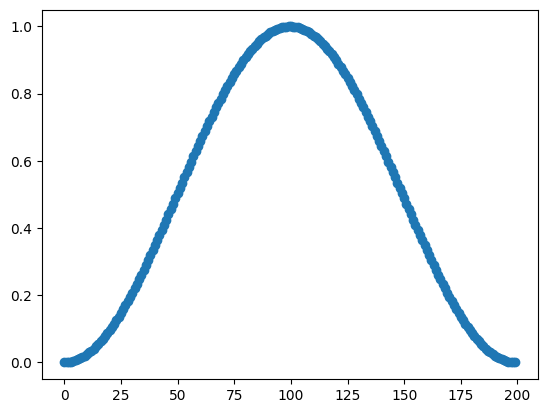

In [7]:
hanning = hanning_window(200)
plot_window(hanning)

In [8]:
def chunk_array(frames: np.ndarray, chunk_size: int, overlap: float) -> Iterator[np.ndarray]:
    """
    frames: The frames of the signal.
    chunk_size: The number of frames each chunk gets.
    overlap: The number of frames the chunks overlap.
    """
    n_frames = frames.shape[0]
    # If only one window exists, return this window directly.
    if n_frames <= chunk_size:
        return [frames]
        
    chunks = []
    for i in range(0, n_frames, chunk_size - overlap):
        if i + chunk_size <= n_frames:
            chunks.append(frames[i:i+chunk_size])
        else:
            chunks.append(frames[n_frames - chunk_size:n_frames])

    return chunks

In [9]:
def apply_window(windows: List[np.ndarray], window_type: str = ""):
    if window_type == "":
        return windows
    elif window_type == "hanning":
        return [window * hanning_window(window.shape[0]) for window in windows]
    else:
        raise ValueError("Invalid window function specified; valid options: ['', 'hanning']")

In [10]:
def window_signal(frames: np.ndarray, window_duration: float = 0.005, overlap_perc: float = 0.5, window_type: str = "", sample_rate: int = 44_100) -> List[np.ndarray]:
    """
    window_size: length of a short term window in seconds
    window_duration: duration of window in seconds
    overlap_perc: overlap percentage (as float) of full window
    sample_rate: The sample rate of the original signal.
    window_type: 
    """
    # Convert the window size from a measurement in seconds to a measurement in frames.
    frames_per_window = math.ceil(window_duration * sample_rate)
    # Calculate the overlap in frames based
    overlap = window_duration * overlap_perc
    frame_overlap = math.ceil(overlap * sample_rate)

    # Split the sample array into windows.
    windows = chunk_array(frames, frames_per_window, frame_overlap)
    # Apply window function.
    windows = apply_window(windows, window_type=window_type)

    return windows

In [11]:
def prepare_phone_data(phone_data: List[TimitObject], window_duration: float = 0.005, overlap_perc: float = 0.5, window_type: str = "", calc_freq=True) -> List[Phone]:
    phones = []
    frequencies = None
    window_freqs = None
    
    for obj in phone_data:
        for position, (phone_type, start, end) in enumerate(obj.phone_timings):
            frames = obj.wav[start:end]
            num_frames = frames.shape[0]
            # Phones shorter than the window length are ignored.
            if num_frames < 80:
                continue
            windows = window_signal(frames, window_duration=window_duration, overlap_perc=overlap_perc, window_type=window_type, sample_rate=obj.sample_rate)
            

            if calc_freq:
                frequencies = np.fft.fft(frames)
                window_freqs = [np.fft.fft(window) for window in windows]

            phone = Phone(name=obj.name, position=position, phone_type=phone_type, frames=frames, num_frames=num_frames, frequencies=frequencies, windows=windows, window_duration=window_duration, sample_rate=obj.sample_rate, window_frequencies=window_freqs)
            phones.append(phone)
    
    return phones

In [12]:
def sort_by_phones(phone_data: List[Phone]) -> Dict[str, List[Phone]]:
    phone_buckets = {}
    for phone in phone_data:
        phone_type = phone.phone_type
        if phone_buckets.get(phone_type):
            phone_buckets[phone_type].append(phone)
        else:
            phone_buckets[phone_type] = [phone]
            
    return phone_buckets

## Phone Recognition using kNN

In this scenario it is assumed that the phone boundaries are already known.

In [13]:
def encode_phone_types(phone_types: List[str], phone_first: bool = True):
    if phone_first:
        return {phone: num for num, phone in enumerate(phone_types)}
    else:
        return {num: phone for num, phone in enumerate(phone_types)}

In [14]:
def split_train_dev(phone_dict: Dict[str, List[Phone]], train_perc: float = 0.8) -> Tuple[Dict[str, List[Phone]]]:
    """
    This method splits training and dev data so that the percentages of the phone_types
    in the overall data are reflected.
    """
    train_split = {}
    dev_split = {}
    for phone_type in phone_dict:
        num_instances = len(phone_dict[phone_type])
        num_train = math.ceil(num_instances * train_perc)
        
        shuffled = random.sample(phone_dict[phone_type], num_instances)
        train_split[phone_type] = shuffled[:num_train]
        dev_split[phone_type] = shuffled[num_train:]
        
    return train_split, dev_split

In [15]:
# Prepare data for KNN classifier.
def prepare_encodings(train_split: Dict[str, List[Phone]], class_encoding) -> Tuple[np.ndarray, np.ndarray]:
    # Prepare the encodings for training so that they come in numpy arrays.
    x = []
    y = []
    for phone_type, phones in train_split.items():
        for phone in phones:
            # Calculate the magnitude of the complex numbers and use it as a representation.
            windows = [np.sqrt(np.square(window.real) + np.square(window.imag)) for window in phone.window_frequencies]

            x.extend(windows)
            y.extend([class_encoding[phone_type]] * len(windows))

    return np.stack(x), np.stack(y)

In [16]:
def infer_phone(knn: KNeighborsClassifier, phone: Phone, class_encoding) -> Tuple[np.ndarray, np.ndarray]:

    # Remove the last window because it has fewer frequencies.
    windows = phone.window_frequencies
    # Calculate the magnitude of the complex numbers and use it as a representation.
    windows = [np.abs(window) for window in windows]
    
    x = np.stack(windows)
    y = class_encoding[phone.phone_type]

    y_pred = knn.predict(x)
    phone_pred = np.bincount(y_pred).argmax()
    
    return phone_pred, y

In [17]:
def calc_dev_metrics(dev_split: Dict[str, List[Phone]], knn: KNeighborsClassifier, class_encoding: Dict[str, int]) -> Tuple[float, List[int], List[int]]:
    """ 
    Calculate accuracy for actual phone prediction.
    Also output all gold and all predicted values for the dev phones.
    """
    all_pred = []
    all_gold = []
    correct = 0
    total = 0

    for phone_type, phones in dev_split.items():
        for phone in phones:
            try:
                pred, gold = infer_phone(knn, phone, class_encoding)
                all_pred.append(pred)
                all_gold.append(gold)
                if pred == gold:
                    correct += 1
                total += 1
            except ValueError:
                pass
    return correct / total, all_gold, all_pred

In [18]:
def train_knn_phone_classifier(n_neighbors: int = 5, weights: str = "uniform"):
    
    timit_data = get_timit_objects(TIMIT_PATH)
    phone_dict = sort_by_phones(prepare_phone_data(timit_data, window_type="hanning", calc_freq=True))
    class_encoding = encode_phone_types(list(phone_dict.keys()))
    train_split, dev_split = split_train_dev(phone_dict, train_perc=0.9)
    
    x_train, y_train = prepare_encodings(train_split, class_encoding)
    x_dev, y_dev = prepare_encodings(dev_split, class_encoding)
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    
    phone_dev_acc, all_gold, all_pred = calc_dev_metrics(dev_split, knn, class_encoding)
    
    frame_dev_preds = knn.predict(x_dev)
    frame_dev_acc = np.equal(frame_dev_preds, y_dev).sum() / frame_dev_preds.shape[0]
    
    return phone_dev_acc, frame_dev_acc, knn

In [19]:
phone_dev_acc, frame_dev_acc, knn = train_knn_phone_classifier()

In [20]:
phone_dev_acc, frame_dev_acc

(0.31197301854974707, 0.2958380202474691)

In [21]:
# confmat = confusion_matrix(all_gold, all_pred)

In [22]:
# print(classification_report(all_gold, all_pred))

In [23]:
# TODO: Implement hyperparameter tuning for the KNN classifier.

# 1. Define an objective function.
def tune_phone_classifier_knn(config):
    phone_dev_acc, _, _ = train_knn_phone_classifier(n_neighbors=config["n_neighbors"], weights=config["weights"])

    return {"score": phone_dev_acc}


# 2. Define a search space.
search_space = {
    "n_neighbors": tune.grid_search([2,3,5,8,10,12,15,20]),
    "weights": tune.choice(["uniform", "distance"]),
}

# 3. Start a Tune run and print the best result.
trainable_with_resources = tune.with_resources(tune_phone_classifier_knn, {"cpu": 8})
tuner = tune.Tuner(trainable_with_resources, param_space=search_space)
results = tuner.fit()
print(results.get_best_result(metric="score", mode="max").config)

2023-04-26 15:18:53,526	INFO worker.py:1553 -- Started a local Ray instance.


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,score,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
tune_phone_classifier_knn_e6583_00000,2023-04-26_15-21-21,True,,899f3c7a99144a95a3d901324621c740,"0_n_neighbors=2,weights=uniform",jannis,1,192.168.2.135,71668,0.320405,139.454,139.454,139.454,1682515281,0,,1,e6583_00000,0.00670958
tune_phone_classifier_knn_e6583_00001,2023-04-26_15-22-38,True,,899f3c7a99144a95a3d901324621c740,"1_n_neighbors=3,weights=uniform",jannis,1,192.168.2.135,71668,0.320405,76.7121,76.7121,76.7121,1682515358,0,,1,e6583_00001,0.00670958
tune_phone_classifier_knn_e6583_00002,2023-04-26_15-23-58,True,,899f3c7a99144a95a3d901324621c740,"2_n_neighbors=5,weights=distance",jannis,1,192.168.2.135,71668,0.310287,79.9681,79.9681,79.9681,1682515438,0,,1,e6583_00002,0.00670958
tune_phone_classifier_knn_e6583_00003,2023-04-26_15-25-51,True,,899f3c7a99144a95a3d901324621c740,"3_n_neighbors=8,weights=distance",jannis,1,192.168.2.135,71668,0.335582,113.092,113.092,113.092,1682515551,0,,1,e6583_00003,0.00670958
tune_phone_classifier_knn_e6583_00004,2023-04-26_15-27-46,True,,899f3c7a99144a95a3d901324621c740,"4_n_neighbors=10,weights=uniform",jannis,1,192.168.2.135,71668,0.322091,114.542,114.542,114.542,1682515666,0,,1,e6583_00004,0.00670958
tune_phone_classifier_knn_e6583_00005,2023-04-26_15-29-38,True,,899f3c7a99144a95a3d901324621c740,"5_n_neighbors=12,weights=distance",jannis,1,192.168.2.135,71668,0.332209,111.667,111.667,111.667,1682515778,0,,1,e6583_00005,0.00670958
tune_phone_classifier_knn_e6583_00006,2023-04-26_15-31-31,True,,899f3c7a99144a95a3d901324621c740,"6_n_neighbors=15,weights=uniform",jannis,1,192.168.2.135,71668,0.352445,113.353,113.353,113.353,1682515891,0,,1,e6583_00006,0.00670958
tune_phone_classifier_knn_e6583_00007,2023-04-26_15-33-23,True,,899f3c7a99144a95a3d901324621c740,"7_n_neighbors=20,weights=distance",jannis,1,192.168.2.135,71668,0.335582,112.159,112.159,112.159,1682516003,0,,1,e6583_00007,0.00670958


2023-04-26 15:33:23,620	INFO tune.py:798 -- Total run time: 866.42 seconds (866.30 seconds for the tuning loop).


{'n_neighbors': 15, 'weights': 'uniform'}


### TODOS:

1. Do hyperparameter tuning
2. Put everything into Python files
3. Makes models storable and readable in a "models" directory -> make subfolders for task and type of model